### 필수과제3
- sales data 중에서 가장 많이 판매되었던 상품을 1, 2, 3, 4까지 라벨링한 후 해당 라벨링 값을 정답으로 하여 위에 배운 내용을 복습하는 코드를 작성

- 해당 데이터는 정답값이 없으므로 우리가 만들어 Decisiontree 모델만 사용하여 진행
- skf를 이용해서 동일하게 micro, macro, weighted를 비교하여 정리
- 1,2,3,4 외에 나머지 데이터는 0으로 라벨링, 데이터 전체 삭제하지마시고 분류

In [27]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/데이터 분석 중급반(6기)/데이터

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/데이터 분석 중급반(6기)/데이터


In [3]:
sales = pd.read_csv("./sales_data.csv", encoding = 'cp437')
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# 전체에서 결측치가 차지하는 비율 확인
round(sales.isnull().sum()/len(sales) * 100,5)

InvoiceNo       0.00000
StockCode       0.00000
Description     0.26831
Quantity        0.00000
InvoiceDate     0.00000
UnitPrice       0.00000
CustomerID     24.92669
Country         0.00000
dtype: float64

In [5]:
# 결측치 대체
sales['Description'] = sales['Description'].fillna("NULL")
sales['CustomerID'] = sales['CustomerID'].fillna(0)
round(sales.isnull().sum()/len(sales) * 100,5)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [6]:
# 데이터의 정보 확인
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  541909 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# 각 열별 unique한 개수 확인
for col in sales.columns:
  print("unique한 {}의 개수 : {}".format(col,len(sales[col].unique())))

unique한 InvoiceNo의 개수 : 25900
unique한 StockCode의 개수 : 4070
unique한 Description의 개수 : 4224
unique한 Quantity의 개수 : 722
unique한 InvoiceDate의 개수 : 23260
unique한 UnitPrice의 개수 : 1630
unique한 CustomerID의 개수 : 4373
unique한 Country의 개수 : 38


In [8]:
# InvoiceDate를 날짜 데이터로 변경
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'])
sales['year'] = sales['InvoiceDate'].dt.year
sales['month'] = sales['InvoiceDate'].dt.month
sales['day'] = sales['InvoiceDate'].dt.day
sales['hour'] = sales['InvoiceDate'].dt.hour
sales['minute'] = sales['InvoiceDate'].dt.minute

In [9]:
# 가장 많이 팔린 상품은 85123A, 22423, 85099B, 84879 순임을 확인 가능
sales['StockCode'].value_counts()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
21431        1
22275        1
17001        1
90187A       1
72759        1
Name: StockCode, Length: 4070, dtype: int64

In [10]:
# 가장 많이 팔린 상품부터 순서대로 1,2,3,4 나머지는 0으로 하는 target list 생성
target = []
for x in sales['StockCode']:
  if x == "85123A":
    target.append(1)
  elif x == "22423":
    target.append(2)
  elif x == "85099B":
    target.append(3)
  elif x == "84879":
    target.append(4)
  else:
    target.append(0)

In [11]:
# 만든 target을 sales의 target열에 추가
sales['target'] = target
sales['target'].value_counts()

0    533732
1      2313
2      2203
3      2159
4      1502
Name: target, dtype: int64

In [12]:
# 전처리 중간점검
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  float64       
 7   Country      541909 non-null  object        
 8   year         541909 non-null  int64         
 9   month        541909 non-null  int64         
 10  day          541909 non-null  int64         
 11  hour         541909 non-null  int64         
 12  minute       541909 non-null  int64         
 13  target       541909 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(4)
memory usage: 57.9+ MB


In [13]:
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,day,hour,minute,target
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,8,26,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,8,26,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,8,26,0


In [14]:
# InvoiceNo, StockCode, Description, Country 범주형으로 변환
cate_list = ["InvoiceNo", "StockCode", "Description", "Country"]
for x in cate_list:
  le = LabelEncoder()
  sales[x] = le.fit_transform(sales[x]) 

In [15]:
# 최종 데이터 확인
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  int64         
 1   StockCode    541909 non-null  int64         
 2   Description  541909 non-null  int64         
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  float64       
 7   Country      541909 non-null  int64         
 8   year         541909 non-null  int64         
 9   month        541909 non-null  int64         
 10  day          541909 non-null  int64         
 11  hour         541909 non-null  int64         
 12  minute       541909 non-null  int64         
 13  target       541909 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(11)
memory usage: 57.9 MB


In [16]:
sales2 = sales.drop('InvoiceDate', axis = 1)

In [17]:
features = sales2.drop('target', axis = 1).to_numpy()
label = sales2['target'].to_numpy()

Counter({0: 533732, 1: 2313, 2: 2203, 3: 2159, 4: 1502})


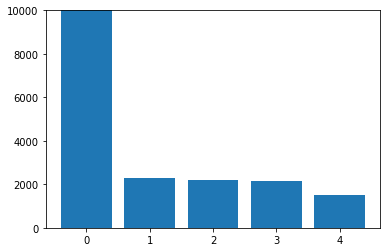

In [35]:
# label의 분포를 확인한 결과 0이 압도적으로 많고, 나머지는 매우 적은 것을 확인 가능
from collections import Counter
counter = Counter(label)
print(counter)
plt.ylim(0,10000)
plt.bar(counter.keys(), counter.values())
plt.show()

Counter({1: 533732, 0: 533732, 4: 533732, 3: 533732, 2: 533732})


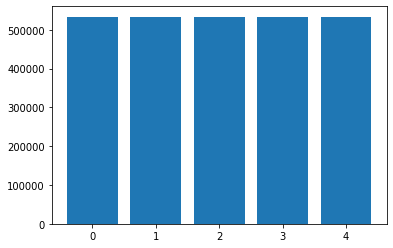

In [36]:
# 데이터 불균형 해소 -> oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE()
over_features, over_label = smote.fit_resample(features, label)
counter = Counter(over_label)
print(Counter(over_label))
plt.bar(counter.keys(), counter.values())
plt.show()

In [22]:
print("Oversampling한 경우의 각 average값 변화 \n")

# 모델 설정
result_skfold = StratifiedKFold(n_splits=3)
result_clf = DecisionTreeClassifier(random_state=100)

n_iter = 0
average = ['micro', 'macro', 'weighted']
for avg in average:
  # 결과 저장 리스트 생성
  cv_accuracy=[]    # accuracy 결과 저장 리스트
  cv_precision=[]   # precision 결과 저장 리스트
  cv_recall=[]      # recall 결과 저장 리스트
  
  print("평균을 {}로 했을 때".format(avg))
  for train_idx, test_idx in result_skfold.split(over_features, over_label):
      
      # train/test data 분리
      X_train, X_test = over_features[train_idx], over_features[test_idx]
      y_train, y_test = over_label[train_idx], over_label[test_idx]

      # 학습 진행 및 예측
      result_clf.fit(X_train, y_train)
      pred = result_clf.predict(X_test)
    
      #정확도 관련해서 측정
      n_iter +=1 
      accuracy = np.round(accuracy_score(y_test, pred),3)
      precision = np.round(precision_score(y_test,pred, average=avg),3)
      recall = np.round(recall_score(y_test, pred, average=avg),3)
      print('{}번째 교차검증 정확도 : {}, 교차검증 precision :{}, 교차검증 recall :{}'.format(n_iter, accuracy, precision, recall))
      cv_accuracy.append(accuracy)
      cv_precision.append(precision)
      cv_recall.append(recall)
  n_iter=0

  print('평균 검증 정확도', np.mean(cv_accuracy), np.mean(cv_precision), np.mean(cv_recall),'\n')

Oversampling한 경우의 각 average값 변화 

평균을 micro로 했을 때
1번째 교차검증 정확도 : 0.845, 교차검증 precision :0.845, 교차검증 recall :0.845
2번째 교차검증 정확도 : 1.0, 교차검증 precision :1.0, 교차검증 recall :1.0
3번째 교차검증 정확도 : 0.997, 교차검증 precision :0.997, 교차검증 recall :0.997
평균 검증 정확도 0.9473333333333334 0.9473333333333334 0.9473333333333334 

평균을 macro로 했을 때
1번째 교차검증 정확도 : 0.845, 교차검증 precision :0.913, 교차검증 recall :0.845
2번째 교차검증 정확도 : 1.0, 교차검증 precision :1.0, 교차검증 recall :1.0
3번째 교차검증 정확도 : 0.997, 교차검증 precision :0.997, 교차검증 recall :0.997
평균 검증 정확도 0.9473333333333334 0.9700000000000001 0.9473333333333334 

평균을 weighted로 했을 때
1번째 교차검증 정확도 : 0.845, 교차검증 precision :0.913, 교차검증 recall :0.845
2번째 교차검증 정확도 : 1.0, 교차검증 precision :1.0, 교차검증 recall :1.0
3번째 교차검증 정확도 : 0.997, 교차검증 precision :0.997, 교차검증 recall :0.997
평균 검증 정확도 0.9473333333333334 0.9700000000000001 0.9473333333333334 

